### ESGF: Simple One Dataset Example 

This example goes through how to access data from Earth System Grid Federation (ESGF) and visualize the data with simple plots. ESGF stores the datasets as netCDF files, but in many cases one dataset can be divided into multiple files.

**Packages:**

- matplotlib
- numpy
- cftime
- nc-time-axis
- xarray 
    - *for handling of multidimensional arrays*
- esgf-pyclinet
    - *for connecting to ESGF*

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

#pyesgf is module in esgf-pyclient library, that is used to import search-functions
from pyesgf.search import SearchConnection

In [2]:
#creates new search connection and connects to esgf 
#conn = SearchConnection('https://esgf-data.dkrz.de/esg-search', distrib=False)
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=False)
#if changed into "True", the search will show duplicates of the same dataset from esgf-dataportals of diffrent countries
#this might be useful when one of the esgf websites happens to have problems

In [3]:
#next we need to define what  we are searching
#(historical monthly near surface temperature from NCAR)
ctx = conn.new_context(
    activity_id= 'CMIP',
    institution_id= 'NASA-GISS',
    experiment_id= 'historical',
    table_id='Amon',
    variable='tas',
    member_id='r6i1p1f1')

#hit count of this search
ctx.hit_count

9

In [4]:
#execute the actual search
results = ctx.search()

#printing the dataset-id of all the results
for res in results:
    print(res.dataset_id)

CMIP6.CMIP.NASA-GISS.GISS-E2-1-H.historical.r6i1p1f1.Amon.tas.gn.v20190403|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r6i1p1f1.Amon.tas.gn.v20180829|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r6i1p1f1.Amon.tas.gn.v20180829|dpesgf03.nccs.nasa.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-H.historical.r6i1p1f1.Amon.tas.gn.v20190403|dpesgf03.nccs.nasa.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r6i1p1f1.Amon.tas.gn.v20180829|esgf-data3.diasjp.net
CMIP6.CMIP.NASA-GISS.GISS-E2-1-H.historical.r6i1p1f1.Amon.tas.gn.v20190403|esgf-data3.diasjp.net
CMIP6.CMIP.NASA-GISS.GISS-E2-2-G.historical.r6i1p1f1.Amon.tas.gn.v20191120|esgf-data1.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-2-G.historical.r6i1p1f1.Amon.tas.gn.v20191120|esgf-data3.diasjp.net
CMIP6.CMIP.NASA-GISS.GISS-E2-2-G.historical.r6i1p1f1.Amon.tas.gn.v20191120|dpesgf03.nccs.nasa.gov


In [5]:
#some datasets are divided into multiple files
#we can do additional search to get the file context for specific dataset
files = results[0].file_context().search()

#pritnting how many files the first result contains
print(len(files))

#when planning to use whole data it might be useful to combine all of the files into one list
files_all = []
for file in files:
    files_all.append(file.opendap_url)

4


In [6]:
#xarray can be used to open the datasets

#if you only need single file and do not need the whole timeseries you can simply open one of the files 
ds_1 = xr.open_dataset(files[0].opendap_url, chunks={'time': 120})
print(ds_1) #gives you better idea what the dataset contains

#the same can be done with the combined list of files we created earlier
ds = xr.open_mfdataset(files_all, chunks={'time': 120}, combine='nested', concat_dim='time')

<xarray.Dataset>
Dimensions:    (time: 612, bnds: 2, lat: 90, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(120, 90, 144), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           36500.0
    contact:       

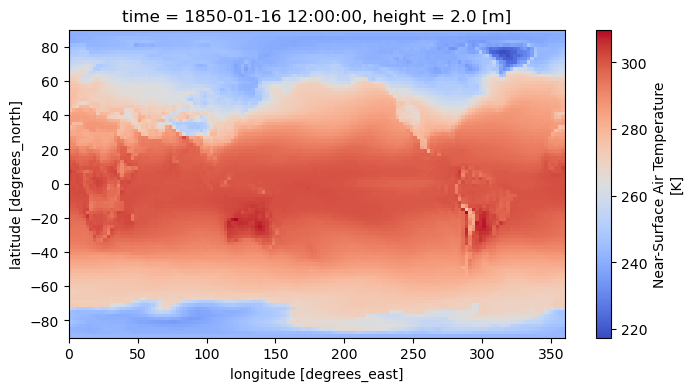

In [7]:
#selecting first point of time
data = ds.tas.isel(time=0)
#plotting as coolwarm colormap
data.squeeze().plot(aspect=2, size=4, cmap=plt.cm.coolwarm)

In [8]:
#temperature data in celsisus degrees
tas = ds.tas - 273.15

In [9]:
#creating weights to weight data according to area
weights = np.cos(np.deg2rad(tas.lat))
weights.name = "weights"

In [10]:
#calculating weighted global means
tas_weighted = tas.weighted(weights)
weighted_mean = tas_weighted.mean(("lon", "lat"))

In [11]:
%time weighted_mean.load()

CPU times: user 3.03 s, sys: 1.11 s, total: 4.14 s
Wall time: 1min 40s


<xarray.DataArray 'tas' (time: 1980)>
array([12.54088177, 12.75420088, 13.55771872, ..., 15.17761118,
       14.3654824 , 13.63337195])
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    height   float64 2.0

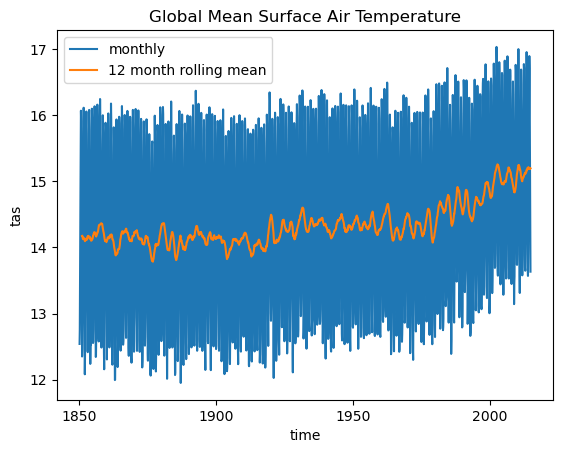

In [12]:
#plotting the weighted global mean and its rolling mean
weighted_mean.plot(label='monthly')
weighted_mean.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.title('Global Mean Surface Air Temperature')
plt.legend()
plt.show()